In [342]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pymc3 as pm
import importlib
import pymc3_utils as pu    ; importlib.reload(pu);
import cologenic_utils as cu; importlib.reload(cu);

# Read in the data

Read in the data from each plate run from `combined_results.csv` files.

In [343]:
from glob import glob
files=glob("analysis-strip/UWB1 pair/*/combined_results.csv")\
     +glob("analysis-strip/summary/*/combined_results.csv")
dfs=[]
for i,file in enumerate(files[:]):
    df = pd.read_csv(file)
    df['plate']=i
    dfs.append(df)
df = pd.concat(dfs,ignore_index=True)

Add indices to group by cell line, drug and (cell_line x drug )

In [344]:
df['i_exp'],df['exp_code']=pu.multilabel_encoder(df,'Cell_line Drug plate'.split(),delim='|')
df['i_cell'],_            =pu.multilabel_encoder(df,'Cell_line'.split(),delim='|')
df['i_drug'],_            =pu.multilabel_encoder(df,'Drug'.split(),delim='|')
df['i_drugcell'],_        =pu.multilabel_encoder(df,'Drug Cell_line'.split(),delim='|')

These are indices of that embed the various subgroups to the experimential data.

In [345]:
cell2ind     = pu.embeded_index(df,'i_exp','i_cell')
drug2ind     = pu.embeded_index(df,'i_exp','i_drug')
drugcell2ind = pu.embeded_index(df,'i_exp','i_drugcell')
drug2drugcell= pu.embeded_index(df,'i_drugcell','i_drug')


### Fit a single data set - logit transform


In [295]:
mask = df['i_exp']==5
dft=df[mask]
cells_plated = dft['Cells Plated'].values
concs        = dft['Treatment'].values
counts       = dft['Count'].values
#cells_plated,concs,counts,label = extract_data(df,5)

with pm.Model() as plated_model:

    
    PE_a = pm.Lognormal("PE_a",2,0.2)
    PE_b = pm.Lognormal("PE_b",4,0.2)
    PE = pm.Beta("PE",alpha=PE_a,beta=PE_b)
    #PE = pm.Beta("PE",alpha=2,beta=4)#,shape=12)
    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE)

    # model coefficents
    alpha = pm.Lognormal('alpha',mu=np.log(0.1),sd=0.4)
    beta  = pm.Lognormal('beta', mu=np.log(0.01),sd=0.4)
 
    #nb_alpha = pm.HalfNormal('nb_alpha',0.02)

    model = pm.Deterministic('model',mu_attach*pm.math.exp(-alpha*concs-(beta*concs)**2))
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_alpha**2,observed=counts)
    yi = pm.Poisson('yi',mu=model,observed=counts)

In [ ]:
with plated_model:
    trace = pm.sample()

In [22]:
def loglike(theta,df):
    PE,a,b = theta[:3]
    c = dft['Treatment']
    return(-sum(stats.poisson.pmf( dft['Count'],dft['Cells Plated']*abs(PE)*np.exp( -abs(a)*c - abs(b*c)**2 ) )))

In [18]:
from matplotlib.ticker import FuncFormatter,NullFormatter
def pow2formatter(x,pos):
    if( x==0): return '0'
    if( x==1): return '1'
    if( x>1 ): 
        n = np.round(np.log2(x))
        return r'${x}$'.format(x=int(x))
        #return r'$2^{n}$'.format(n=int(n))
    if( x<1 ): 
        n = -np.round(np.log2(x))
        return r'$\frac{{1}}{{{x}}}$'.format(x=int(1/x))
        #return r'$\frac{{1}}{{2^{n}}}$'.format(n=int(n))


In [17]:
def posterior_comp( ax, df, trace, ind):
    ''''''
    # get the experimental unit
    dft = df[df['i_exp']==ind].copy()
    dft.sort_values('Treatment',inplace=True)

    ax.plot(dft['Treatment'],dft['Count'],'o')


    pulls = pull_post(trace,'PE alpha beta'.split(),ind)
    
    xp = np.array([0]+np.power(10,np.linspace(-5,2,61)))
    nsamp=400
    samps = np.zeros([nsamp,len(xp)])
    cp = np.median(dft['Cells Plated'])
    for i in range(nsamp):
        ir = np.random.randint(pulls.shape[0])
        samps[i] =LQ_model(xp, cp*pulls[ir,0],pulls[ir,1],pulls[ir,2])
    perc_plot(ax,xp,samps,color='red')
    
def posterior_comp_sigmoid( ax, df, trace, ind):
    # get the experimental unit
    dft = df[df['i_exp']==ind].copy()
    dft.sort_values('Treatment',inplace=True)

    ax.plot(dft['Treatment'],dft['Count'],'o')


    pulls = pull_post(trace,'PE sfrac LC50 slope nu'.split(),ind)
    
    xp = np.array([0]+np.power(10,np.linspace(-5,2,61)))
    nsamp=400
    samps = np.zeros([nsamp,len(xp)])
    cp = np.median(dft['Cells Plated'])
    for i in range(nsamp):
        ir = np.random.randint(pulls.shape[0])
        samps[i] =cp*pulls[ir,0]*sigmoid_curve(xp,*pulls[ir,1:])
    perc_plot(ax,xp,samps,color='red')


### Fit whole dataset

In [346]:
exp_idx      = df['i_exp'].values; nexp   = max(exp_idx)+1
counts       = df['Count'].values; ncount = len(counts)
concs        = df['Treatment'].values
cells_plated = df['Cells Plated'].values
labels       = df['Experiment Title'].values

In [347]:
import theano.tensor as tt
with pm.Model() as hm_test:
    PE_lo = pm.Normal('PE_lo',mu=-0.3, sd=3, shape=nexp)
    PE    = pm.Deterministic('PE', cu.invlogit(PE_lo) )
    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE[exp_idx])
    
    alpha = pm.Lognormal('alpha',mu=np.log(2),sd=0.5,shape=nexp)
    beta  = pm.Lognormal('beta', mu=np.log(0.1),sd=0.5,shape=nexp)
    

    model = cu.LQ_model( concs, mu_attach, alpha[exp_idx],beta[exp_idx]) 
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_al
    yi = pm.Poisson('yi',mu=model,observed=counts)

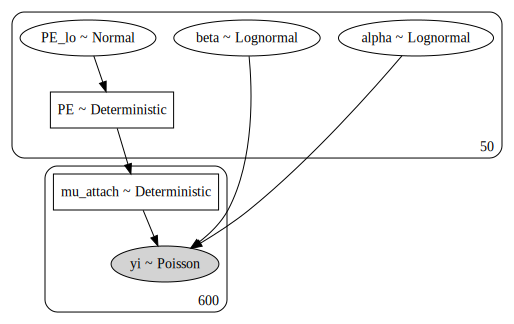

In [348]:
pm.model_to_graphviz(hm_test)

In [349]:
with hm_test:
    trace_dhit = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, PE_lo]
Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 397.55draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### Unpooled model

In [172]:
import theano.tensor as tt
with pm.Model() as hm_test_up:
    PE_lo = pm.Normal('PE_lo',mu=-0.3, sd=3, shape=nexp)
    PE    = pm.Deterministic('PE', cu.invlogit(PE_lo) )

    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE[exp_idx])
    
    
    LC50_l = pm.Normal("LC50_l", mu=np.log(0.2),sd=4,shape=nexp)
    LC50   = pm.Deterministic('LC50',tt.exp(LC50_l))
    #sfrac = pm.Beta('sfrac',1,35,shape=nexp)
    sfrac = pm.Deterministic('sfrac',tt.zeros(nexp))
    #LC50  = pm.Lognormal('LC50'   ,mu=np.log(2),sd=0.2,shape=nexp)
    slope  = pm.Lognormal('slope', mu=np.log(1),sd=0.2,shape=nexp)
    
    #nu     = pm.Lognormal('nu',    mu=np.log(1),sd=0.2,shape=nexp)
    nu_l = pm.Normal('nu_l',np.log(1),sd=0.2,shape=nexp)
    nu  = pm.Deterministic('nu',tt.exp(nu_l))
     

    model = pm.Deterministic('model',mu_attach*sigmoid_curve( concs,sfrac[exp_idx],LC50[exp_idx],slope[exp_idx],nu[exp_idx]) )
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_al
    yi = pm.Poisson('yi',mu=model,observed=counts)

In [173]:
with hm_test_up:
    trace_up = pm.sample(start={'sfrac':0.02})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_l, slope, LC50_l, PE_lo]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 240.73draws/s]


Text(0.5, 0, 'Concentration of drug')

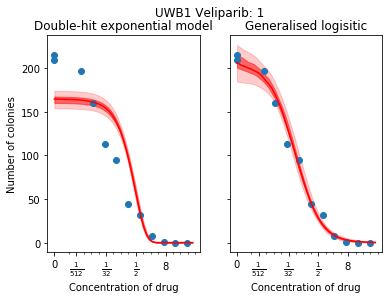

In [356]:
iplt=8
fig,axs = plt.subplots(1,2,sharex=True,sharey=True)
fig.suptitle( cu.get_exp_label(df,iplt))
ax = axs[0]
ax.set_title('Double-hit exponential model')
cu.posterior_comp(ax,df,trace_dhit,iplt)
ax.set_xscale('symlog', linthreshx=1E-3,basex=2)
ax.set_xlabel("Concentration of drug")
ax.set_ylabel("Number of colonies")

formatter = FuncFormatter(pow2formatter)
ax.xaxis.set_major_formatter(formatter);
locs = [0]+[2**n for n in range(-9,4,4)]
ax.set_xticks(locs);

ax =axs[1]
ax.set_title('Generalised logisitic')
cu.posterior_comp_sigmoid(ax,df,trace_up,iplt)
ax.set_xlabel("Concentration of drug")


### Pooled model

In [383]:
ncell = len(df['i_cell'].unique())
ndrug = len(df['i_drug'].unique())
ndrugcell = len(df['i_drugcell'].unique())
import theano.tensor as tt
with pm.Model() as hm_test:
    vdict={}
    # plating efficenct
    PE_lo_mu = pm.Normal    ('PE_lo_mu',mu=-1, sd=3, shape=ncell)
    PE_lo_sd = pm.HalfNormal('PE_lo_sd',sd=0.2,      shape=ncell)
    
    PE_lo = pm.Deterministic('PE_lo',            PE_lo_mu[cell2ind]+\
        pm.Normal("PE_lod",mu=0,sd=1,shape=nexp)*PE_lo_sd[cell2ind])
    PE    = pm.Deterministic('PE', cu.invlogit(PE_lo) )

    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE[exp_idx])
    
    # drugs have common dist
    pu.add_2level_hierarchy('LC50_l',vdict, np.log(0.1),5., 0.1, 0.05,  drugcell2ind)
    LC50 = pm.Deterministic('LC50', tt.exp(vdict['LC50_l']))
    
    pu.add_2level_hierarchy('slope_l', vdict, np.log(0.15),0.4, 0.2, 0.1, drugcell2ind)
    slope= pm.Deterministic('slope',tt.exp(vdict['slope_l']))
        
    pu.add_2level_hierarchy('nu_l', vdict, np.log(1),0.2, 0.1, 0.1, drugcell2ind)
    nu= pm.Deterministic('nu',tt.exp(vdict['nu_l']))  
    
    if( False):
        sfrac_lo_mu = pm.Normal    ('sfrac_lo_mu',mu=np.log(0.02), sd=1, shape=ndrugcell)
        sfrac_lo_sd = pm.HalfNormal('sfrac_lo_sd',sd=0.05,      shape=ndrugcell)
    
        sfrac_lo = pm.Deterministic('sfrac_lo',      sfrac_lo_mu[drugcell2ind]+\
         pm.Normal("sfrac_lod",mu=0,sd=1,shape=nexp)*sfrac_lo_sd[drugcell2ind])
    
        
        sfrac    = pm.Deterministic('sfrac', invlogit(sfrac_lo) )
    sfrac_l = pu.add_2level_hierarchy('sfrac_l',vdict, np.log(0.02),0.2,0.1,0.1,drugcell2ind)
    sfrac = pm.Deterministic('sfrac',tt.exp(vdict['sfrac_l']))
    #sfrac = pm.Deterministic('sfrac',tt.zeros(nexp))

    

    #model = pm.Deterministic('model',mu_attach*
    #                          cu.sigmoid_curve( concs,sfrac[exp_idx],LC50[exp_idx],slope[exp_idx],nu[exp_idx]) )
    model = mu_attach* cu.sigmoid_curve( concs,sfrac[exp_idx],LC50[exp_idx],slope[exp_idx],nu[exp_idx])
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_al
    yi = pm.Poisson('yi',mu=model,observed=counts)

In [384]:
with hm_test:
    trace = pm.sample(draws=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dsfrac_l_l0c, dsfrac_l_l0ss, dsfrac_l_l1c, dsfrac_l_l1s, sfrac_l_l2, dnu_l_l0c, dnu_l_l0ss, dnu_l_l1c, dnu_l_l1s, nu_l_l2, dslope_l_l0c, dslope_l_l0ss, dslope_l_l1c, dslope_l_l1s, slope_l_l2, dLC50_l_l0c, dLC50_l_l0ss, dLC50_l_l1c, dLC50_l_l1s, LC50_l_l2, PE_lod, PE_lo_sd, PE_lo_mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [02:11<00:00, 61.06draws/s] 
The number of effective samples is smaller than 10% for some parameters.


In [408]:
def get_exp_index( df, drug, cell_line, rep ):
    mask = (df['Drug']==drug)&(df['Cell_line']==cell_line)
    dft = df[mask].copy()
    plates = dft['plate'].unique()
    
    return dft[dft['plate']==plates[rep]].iloc[0]['i_exp']

In [409]:
get_exp_index(df,'Rucaparib','PEO4',1)

38

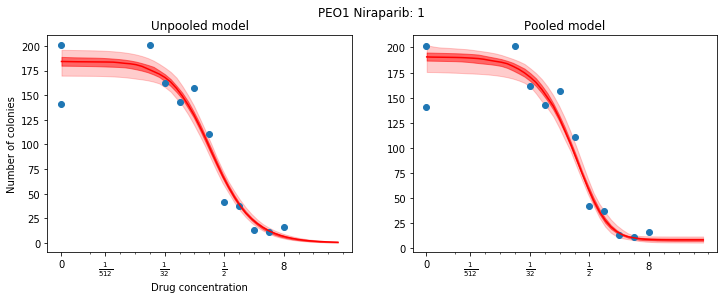

In [417]:
iplt=get_exp_index(df,'Niraparib','PEO1',2)
fig,axs = plt.subplots(1,2,sharex=True,figsize=(12,4))
fig.suptitle(cu.get_exp_label(df,iplt))
ax=axs[0]
ax.set_title("Unpooled model")
posterior_comp_sig(ax,df,trace_up,iplt)
ax.set_ylabel("Number of colonies")
ax.set_xlabel("Drug concentration")

ax=axs[1]
ax.set_title("Pooled model")
posterior_comp_sig(ax,df,trace,   iplt)



ax.set_xscale('symlog', linthreshx=1E-3,basex=2)
formatter = FuncFormatter(pow2formatter)
ax.xaxis.set_major_formatter(formatter);
locs = [0]+[2**n for n in range(-9,4,4)]
ax.set_xticks(locs);




0.4182142170595864


Text(0, 0.5, 'Cells')

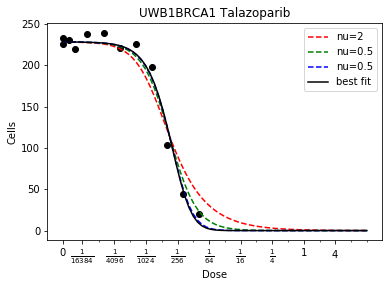

In [386]:
iplt=15

fig,ax = plt.subplots(1,1)
#posterior_comp_sig(ax,df,trace_up,iplt)
dft = df[df['i_exp']==iplt]
ax.plot( dft['Treatment'],dft['Count'],'o',color='k')

ax.set_xscale('symlog', linthreshx=1E-4,basex=2)
formatter = FuncFormatter(pow2formatter)
ax.xaxis.set_major_formatter(formatter);
locs = [0]+[2**n for n in range(-14,4,2)]
ax.set_xticks(locs);


PE = np.median(trace.get_values('PE')[:,iplt])
LC50= np.median(trace.get_values('LC50')[:,iplt])
slope= np.median(trace.get_values('slope')[:,iplt])
nu = np.median(trace.get_values('nu')[:,iplt])
cp=dft['Cells Plated'].median()
print(nu)
xp =np.array([0.]+[2**n for n in np.linspace(-18,4,81)])

choice='nu'
if( choice=='LC50'):
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,2**-2, slope,nu),color='red' ,ls='--',label=r'LC50$=2^{-8}$')
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,LC50, slope,nu),color='green' ,label='best fit')
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,2**-4, slope,nu),color='blue' ,ls='--',label=r'LC50$=2^{-10}$')
if( choice=='slope'):
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,LC50, 2,nu),color='red' ,ls='--',label='slope=2')
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,LC50, slope,nu),color='green' ,label='best fit')
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,LC50, 1,nu),color='blue' ,ls='--',label='slope=1')
if( choice=='nu'):
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,LC50, slope,2),color='red' ,ls='--',label='nu=2')    
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,LC50, slope,1),color='green' ,ls='--',label='nu=0.5')
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,LC50, slope,0.5),color='blue' ,ls='--',label='nu=0.5')
    plt.plot(xp,cp*PE*sigmoid_curve(xp,0.,LC50, slope,nu),color='k' ,label='best fit')
    
drug = dft['Drug'].values[0]
cell_line = dft['Cell_line'].values[0]
ax.set_title("{} {}".format(cell_line,drug))
ax.legend()
ax.set_xlabel("Dose")
ax.set_ylabel("Cells")

In [387]:
# get the order of the drugs LC50, we will order the plots by these 
drug2drugcell
lc50s = np.median(trace.get_values('dLC50_l_l1'),axis=0)
lc50_d = np.zeros(len(np.unique(drug2drugcell)) )
for i in np.unique(drug2drugcell):
    lc50_d[i]=np.average( lc50s[drug2drugcell==i] )
isort = np.argsort(lc50_d)
drugsort=drugnames[isort]

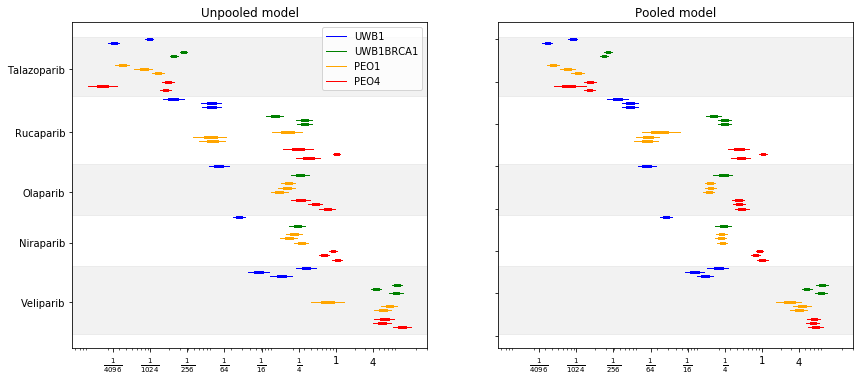

In [418]:
fig,axs = plt.subplots(1,2,figsize=(14,6),sharex=True)
ax = axs[0]
ax.set_title('Unpooled model')
cu.var_comp(ax,df,trace_up,'LC50',drugs=drugsort,legend='upper right',label_plate=False)
ax = axs[1]
ax.set_title('Pooled model')
cu.var_comp(ax,df,trace   ,'LC50',drugs=drugsort,label=False)
axs[0].set_xscale('log')
set_pow2format(axs[0],[2**n for n in range(-12,3,2)])


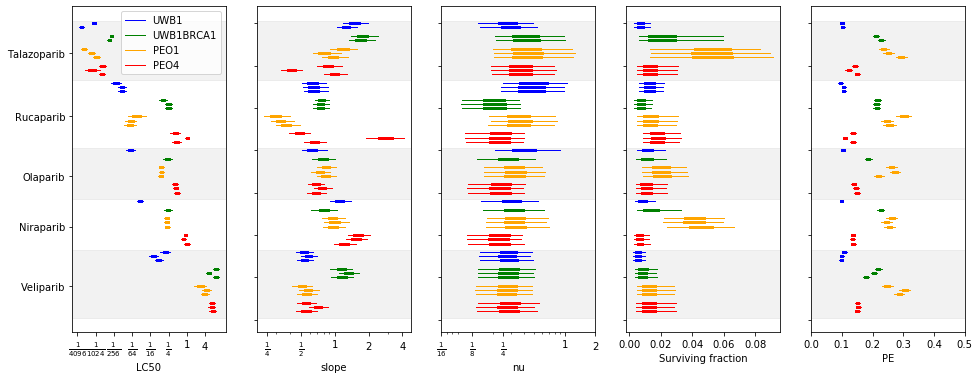

In [424]:
fig,axs = plt.subplots(1,5,figsize=(16,6))

axs[0].set_xlabel('LC50')
cu.var_comp(axs[0],df,trace,'LC50',drugs=drugsort,legend='upper right')
axs[0].set_xscale('log')
set_pow2format(axs[0],[2**n for n in range(-12,3,2)])

axs[1].set_xlabel('slope')
cu.var_comp(axs[1],df,trace   ,'slope',drugs=drugsort,label=False)
axs[1].set_xscale('log')
set_pow2format(axs[1],[0.25,0.5,1,2,4])

axs[2].set_xlabel('nu')
cu.var_comp(axs[2],df,trace   ,'nu',drugs=drugsort,label=False)
axs[2].set_xscale('log')
set_pow2format(axs[2],[1/16.,1/8.,1/4.,1,2])

axs[3].set_xlabel('Surviving fraction')
cu.var_comp(axs[3],df,trace,'sfrac',drugs=drugsort,label=False)

axs[4].set_xlabel('PE')
axs[4].set_xlim(0,0.5)
cu.var_comp(axs[4],df,trace,'PE', drugs=drugsort,label=False)



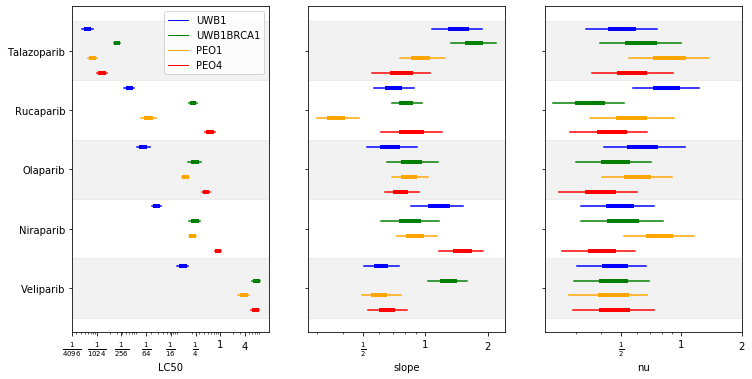

In [273]:
fig,axs = plt.subplots(1,3,figsize=(12,6))

ax=axs[0]
ax.set_xlabel("LC50")
cu.var_comp_level1(ax,df,trace,'LC50_l',transform=np.exp, drugs=drugsort, legend='upper right')
ax.set_xscale('log')
set_pow2format(ax,[2**n for n in range(-12,3,2)])

ax=axs[1]
ax.set_xlabel("slope")
cu.var_comp_level1(ax,df,trace,'slope_l',transform=np.exp,drugs=drugsort, label=False)
ax.set_xscale('log')
set_pow2format(ax,[2**n for n in range(-1,2,1)])

ax=axs[2]
ax.set_xlabel("nu")
cu.var_comp_level1(ax,df,trace,'nu_l',transform=np.exp,drugs=drugsort, label=False)
ax.set_xscale('log')
set_pow2format(ax,[2**n for n in range(-1,2,1)])



In [ ]:

with pm.Model() as hm_test:

    # priors of level 1 distribution
    mu_lo_hp_l = pm.Normal    ('mu_lo_hp_l',    mu=-1.5,sd=2)
    mu_lo_hp_s = pm.HalfNormal('mu_lo_hp_s',    2)
    mu_lo_1 =  pm.Deterministic('mu_lo_1',  mu_lo_hp_l+mu_lo_hp_s*pm.Normal('mu_lo_1_t', mu=0, sd=1,shape=nexp ))
    
    
    # experiment level 1 (centered dist)
    sd_lo_hp_l = pm.Normal    ('sd_lo_hp_l',   mu=0,sd=1 )
    sd_lo_hp_s = pm.Exponential('sd_lo_hp_s',   0.2) 
    sd_lo_1 =  pm.Deterministic('sd_lo_1',pm.math.exp(sd_lo_hp_l+sd_lo_hp_s*pm.Normal('sd_lo_1_t', mu=0 ,sd=1,shape=nexp )))
    
    PE_lo = pm.Normal('PE_lo',mu=mu_lo_1[exp_idx], sd=sd_lo_1[exp_idx], shape=len(exp_idx))
    #PE_lo = pm.Deterministic('PE_lo',mu_lo_1[exp_idx])
    PE    = pm.Deterministic('PE', invlogit(PE_lo) )

    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE)
    
    
    # model coefficents
    alpha = pm.Lognormal('alpha',mu=np.log(0.15),sd=0.3,shape=nexp)
    beta  = pm.Lognormal('beta', mu=np.log(0.01),sd=0.3,shape=nexp)
    

    model = pm.Deterministic('model',LQ_model( concs, mu_attach, alpha[exp_idx],beta[exp_idx]) )
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_alpha**2,observed=counts)
    yi = pm.Poisson('yi',mu=model,observed=counts)

In [ ]:
with hm_test:
    trace = pm.sample(start={'mu_lo_hp_l':-1.5})

In [ ]:
df_fit = pd.DataFrame(columns="Experiment Title,PE,PE_lo,PE_sd_lo,alpha,alpha_err,beta,beta_err,ind".split(','))
#df_fit.columns
df_fit.set_index("Experiment Title",inplace=True)


for il in np.unique(exp_idx):

    mask = exp_idx==il
    label = labels[exp_idx==il][0]
    for var in 'PE PE_lo '.split():
        vals = trace.get_values(var)[:,mask]
        df_fit.loc[label,var] =np.median(vals)
    for var in 'alpha beta sd_lo_1'.split():
        vals = trace.get_values(var)[:,il]
        df_fit.loc[label,var] =np.median(vals)        
    df_fit.loc[label,'ind']=il

In [ ]:
df

In [ ]:
iexp=4
dft=df[exp_idx==iexp]
plt.plot( dft['Treatment'],dft['Count']/dft['Cells Plated'],'o')

### New heading

In [25]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
def perc_plot( ax, time, samp, **kwargs ):
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    percs = np.percentile( samp, [2.5,25,50,75,97.5], axis=0)
    ax.fill_between( time, percs[0],percs[4], alpha=0.2, **kwargs )
    ax.fill_between( time, percs[1],percs[3], alpha=0.5, **kwargs )
    ax.plot( time, percs[2], lw=1.5, **kwargs )
    return

In [23]:
def pull_post(  trace,varnames, il=1, nsamp=100):
    post = np.zeros([nsamp,len(varnames)])
    for i,var in enumerate(varnames):
        vals = trace.get_values(var)
        if( i==0 ):
            # first time through make the sampling array
            isamp =np.random.randint(vals.shape[0],size=nsamp)
 
        if( len((vals.shape))==1 ):
            post[:,i]=vals[isamp]
        if( len((vals.shape))==2 ):
            post[:,i]=vals[isamp,il]
    return post

In [ ]:
df.head()

In [ ]:
il=3
post = pull_post(trace,'PE alpha beta'.split(),il=il)
mask=df['exp_ind']==il
dft = df[mask]
x0 = dft['Treatment']
y0 = dft['SF']
c = np.array([0.]+np.exp(np.linspace(-5,np.log(60),41)))
plt.plot(x0,y0,'o')

    
cc = df['Treatment']
cp = df['Cells Plated']
for i in range(10):
    plt.plot(cc,LQ_model(cc,*post[i]),'o',color='grey')

In [ ]:
fig,axs = plt.subplots(2,3,sharey=True,figsize=(12,10))
for i,ii in enumerate([0,4,5]):
    ax=axs[0,i]
    plot_post( ax, df,exp_idx, trace, ii)
for i,ii in enumerate([1,2,3]):
    ax=axs[1,i]
    plot_post( ax, df,exp_idx, trace, ii)

In [ ]:
il=0
def plot_plating(ax,df,exp_idx, trace,il):
    mask = exp_idx==il
    label=df['Experiment Title'][mask].unique()[0]
    
    post1 = []
    post2 = []
    for i in range(50):
        isamp = np.random.randint(0,50)
        cc    = df['Treatment'].values[exp_idx==il]
        isort = np.argsort(cc)
        cc = cc[isort]
        cp    = df['Cells Plated'].values[exp_idx==il][isort]

        PE    = trace.get_values('PE')[isamp,exp_idx==il][isort]
        PE_m = logit(trace.get_values('mu_lo_1')[isamp,il])
        post1.append(PE)
        post2.appe96ones_like(cc))
    perc_plot(ax,cc,post1,color='red')
    perc_plot(ax,cc,post2,color='blue')
    ax.grid()
    ax.set_title(label)

fig,axs = plt.subplots(2,3,sharey=True,figsize=(12,10))
for i,ii in enumerate([0,4,5]):
    ax=axs[0,i]
    plot_plating( ax, df,exp_idx, trace, ii)
for i,ii in enumerate([1,2,3]):
    ax=axs[1,i]
    plot_plating( ax, df,exp_idx, trace, ii)
ax.set_ylim(0,0.45)

In [ ]:
for i in range()

In [ ]:
i1,i2=0,4
fig,axs = plt.subplots(6,6,sharex=True,sharey=True,figsize=(12,12))
for i in range(6):
    for j in range(6):
        ax = axs[i,j]
        
        ax.set_aspect('equal')
        ax.set_xlim(0,0.4)
        ax.set_ylim(0,0.4)
        
        if(i==j): continue
        ax.plot([0,0.5],[0.,0.5],'--',color='red')
        ax.plot( np.median(trace.get_values('PE'),axis=0)[exp_idx==i],np.median(trace.get_values('PE'),axis=0)[exp_idx==j],'o')
        
        

In [ ]:
plt.plot( concs,counts,'o')

x=np.linspace(0,60,101)
Xp = np.stack([cells_plated[0]*np.ones_like(x),x],axis=1)
plt.plot( model2([0.23,0.025,0],Xp))

In [ ]:
hm_test.mode

In [160]:
ncell = len(df['i_cell'].unique())
ndrug = len(df['i_drug'].unique())
ndrugcell = len(df['i_drugcell'].unique())
import theano.tensor as tt
with pm.Model() as hm_test:
    
    PE_lo_mu = pm.Normal    ('PE_lo_mu',mu=-1, sd=3, shape=ncell)
    PE_lo_sd = pm.HalfNormal('PE_lo_sd',sd=0.2,      shape=ncell)
    
    PE_lo = pm.Deterministic('PE_lo',            PE_lo_mu[cell2ind]+\
        pm.Normal("PE_lod",mu=0,sd=1,shape=nexp)*PE_lo_sd[cell2ind])
    
    
    PE    = pm.Deterministic('PE', cu.invlogit(PE_lo) )

    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE[exp_idx])
    
    

    # drugs have common dist
    if( False ):
        LC50_l_mu = pm.Normal    ("LC50_l_mu", mu=np.log(0.2),sd=4,shape=ndrug)
        LC50_l_sd = pm.HalfNormal("LC50_l_sd", 0.1, shape=ndrug)

        LC50_l = pm.Deterministic('LC50_l',           LC50_l_mu[drug2ind]+\
            pm.Normal("LC50_ld",mu=0,sd=1,shape=nexp)*LC50_l_sd[drug2ind])
    if( True):
        # drug x cell have common dist
        LC50_l_mu = pm.Normal    ("LC50_l_mu", mu=np.log(0.2),sd=4,shape=ndrugcell)
        LC50_l_sd = pm.HalfNormal("LC50_l_sd", 0.15,                shape=ndrugcell)      
        
        LC50_l = pm.Deterministic('LC50_l',           LC50_l_mu[drugcell2ind]+\
            pm.Normal("LC50_ld",mu=0,sd=1,shape=nexp)*LC50_l_sd[drugcell2ind])
    LC50   = pm.Deterministic('LC50',tt.exp(LC50_l))
    
    if( True ):
        # drug x cell have common dist
        
        slope_l_sd2 = pm.Lognormal('slope_l_sd2',mu=np.log(0.15),sd=0.2)
        #slope_l_sd2 = pm.Exponential('slope_l_sd2',0.1)
        
        slope_l_mu_sd = pm.HalfNormal('slope_l_mu_sd',0.4) 
        slope_l_mu_mu = pm.Normal    ('slope_l_mu_mu',mu=0,sd=0.75) 
        
        slope_l_mu = pm.Normal    ("slope_l_mu", mu=slope_l_mu_mu,sd=slope_l_mu_sd,shape=ndrugcell)
        slope_l_sd = pm.HalfNormal("slope_l_sd", slope_l_sd2,        shape=ndrugcell)      
        
        slope_l = pm.Deterministic('slope_l',          slope_l_mu[drugcell2ind]+\
            pm.Normal("slope_ld",mu=0,sd=1,shape=nexp)*slope_l_sd[drugcell2ind])
        slope= pm.Deterministic('slope',tt.exp(slope_l))
    else:
        
        slope  = pm.Lognormal('slope', mu=np.log(1),sd=0.1,shape=nexp)
        
    if( True):
        #nu_l_sd_2 = pm.Lognormal('nu_l_sd_2',np.log(0.2),sd=0.1)
        
        nu_l_mu = pm.Normal    ("nu_l_mu", mu=np.log(1),sd=0.1,shape=ndrugcell)
        nu_l_sd = pm.HalfNormal("nu_l_sd", 0.075,               shape=ndrugcell)      
        
        nu_l = pm.Deterministic('nu_l',             nu_l_mu[drugcell2ind]+\
            pm.Normal("nu_ld",mu=0,sd=1,shape=nexp)*nu_l_sd[drugcell2ind])
        nu= pm.Deterministic('nu',tt.exp(nu_l))       
    else:
        nu     = pm.Lognormal('nu',    mu=np.log(1),sd=0.02,shape=nexp)    
        
    if( False):
        sfrac_lo_mu = pm.Normal    ('sfrac_lo_mu',mu=np.log(0.02), sd=1, shape=ndrugcell)
        sfrac_lo_sd = pm.HalfNormal('sfrac_lo_sd',sd=0.05,      shape=ndrugcell)
    
        sfrac_lo = pm.Deterministic('sfrac_lo',      sfrac_lo_mu[drugcell2ind]+\
         pm.Normal("sfrac_lod",mu=0,sd=1,shape=nexp)*sfrac_lo_sd[drugcell2ind])
    
        
        sfrac    = pm.Deterministic('sfrac', invlogit(sfrac_lo) )
    if(False):
        sfrac = pm.Beta('sfrac',1,35,shape=nexp)
    sfrac = pm.Deterministic('sfrac',tt.zeros(nexp))

    

    model = pm.Deterministic('model',mu_attach*cu.sigmoid_curve( concs,sfrac[exp_idx],LC50[exp_idx],slope[exp_idx],nu[exp_idx]) )
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_al
    yi = pm.Poisson('yi',mu=model,observed=counts)

NameError: name 'np' is not defined